In [1]:
## Import dependencies

import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time


# Set default plot size
plt.rcParams["figure.figsize"] = (30,20)

# Define number of epochs used later in training
num_epochs = 1000


# Identification part of the filenames
model_base_name = 'LogCombined1Distribution'
dataset_base_name = 'Combined1Distribution'
base_dir = '/path/to/base/directory'   # Set base directory

## Train Transformer on dataset of 44 metabolites

In [2]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
ModelName = f"Transformer_44met_{model_base_name}Dist_TrainingAndValidation_ForManuscript_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir(base_dir+'/DL-NMR-Optimization/ModelPerformanceMetrics/') 
seed = 1
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [3]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra = np.load(f'Dataset44_{dataset_base_name}_ForManuscript_Spec.npy')
conc1 = np.load(f'Dataset44_{dataset_base_name}_ForManuscript_Conc.npy')


# Transform data using log transformation to compress dynamic range
b = 1000  # compression constant
spectra = np.log10(1+spectra*b)   # perform transformation
OvMax = spectra.max()   # determine max value, for scaling entire range from 0 to 1
spectra = spectra/OvMax   # scale data
print(OvMax)   

3.000434077479319


In [4]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [5]:
## Set up data for testing and training

# Split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(spectra, conc1, test_size = 0.2, random_state = 1)

# Tensorize and prepare datasets
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


# Move the input data to the GPU device
X_train = X_train.to(device)
X_test = X_test.to(device)
#spectraVal = torch.tensor(spectraVal).float().to(device)   # Confusing names, these spectra are the 5000 spectra generated like the training dataset
#ValSpectra = torch.tensor(ValSpectra).float().to(device)   # Confusing names, these spectra are the 10 representative example spectra

# Move the target data to the GPU device
y_train = y_train.to(device)
y_test = y_test.to(device)
#concVal = torch.tensor(concVal).float().to(device)
#ValConc = torch.tensor(ValConc).float().to(device)

# More data prep?
datasets = torch.utils.data.TensorDataset(X_train, y_train)
Test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
train_iter = torch.utils.data.DataLoader(datasets, batch_size = 76, shuffle=True)
test_iter = torch.utils.data.DataLoader(Test_datasets, batch_size = 76, shuffle=True)

In [6]:
del X_train
del X_test
del y_train
del y_test
del spectra
del conc1
del datasets
del Test_datasets

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class Transformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(Transformer, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.decoder = nn.Linear(23552, 44)

    def forward(self, x):
        # Binning
        batch_size, seq_length = x.size()
        num_bins = seq_length // self.input_dim
        x = x.view(batch_size, num_bins, self.input_dim)  # (batch_size, num_bins, input_dim)
        
        # Embedding
        x = self.embedding(x)  # (batch_size, num_bins, d_model)
        
        # Add positional encoding
        x = self.positional_encoding(x)
        
        # Transformer Encoder
        x = x.permute(1, 0, 2)  # (num_bins, batch_size, d_model)
        x = self.transformer_encoder(x)  # (num_bins, batch_size, d_model)
        x = x.permute(1, 0, 2)  # (batch_size, num_bins, d_model)
        
        # Reconstruct original sequence
        x = x.reshape(batch_size, num_bins * d_model)
        
        # Decoding
        x = self.decoder(x)  # (batch_size, output_dim)
        
        return x

# Parameters
input_dim = 1000  # Size of each bin
d_model = 512     # Embedding dimension
nhead = 1         # Number of attention heads
num_encoder_layers = 1  # Number of transformer encoder layers
dim_feedforward = 2048  # Feedforward dimension
dropout = 0.0     # Dropout rate


In [8]:
class RelativeAbsoluteError(nn.Module):
    def __init__(self):
        super(RelativeAbsoluteError, self).__init__()

    def forward(self, y_pred, y_true):
        # Compute the mean of the true values
        y_mean = torch.mean(y_true)
        
        # Compute the absolute differences
        absolute_errors = torch.abs(y_true - y_pred)
        mean_absolute_errors = torch.abs(y_true - y_mean)
        
        # Compute RAE
        rae = torch.sum(absolute_errors) / torch.sum(mean_absolute_errors)
        return rae

In [9]:
def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = RelativeAbsoluteError()
    optimizer = optim.AdamW(model.parameters(), lr=0.00014656680844397094, weight_decay=0.01)
    
    
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    epochs_no_improve = 0
    patience = 50  # Set how many epochs without improvement in validation loss constitutes early stopping

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)
            
            
        if (epoch + 1) % 1 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
            
    
            
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break



    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag

In [10]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir(base_dir+'/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Create model
model_aq = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Move the model to the GPU device
model_aq.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model_aq, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

/home/htjhnson/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


No pretrained model found. Training from scratch.
Epoch [1/1000], Train Loss: 8927.4361, Test Loss: 1756.2093
Epoch [2/1000], Train Loss: 5105.0840, Test Loss: 925.8992
Epoch [3/1000], Train Loss: 2907.6694, Test Loss: 595.8750
Epoch [4/1000], Train Loss: 2012.6352, Test Loss: 447.1302
Epoch [5/1000], Train Loss: 1603.9725, Test Loss: 361.6272
Epoch [6/1000], Train Loss: 1380.5458, Test Loss: 320.0006
Epoch [7/1000], Train Loss: 1204.2084, Test Loss: 291.1654
Epoch [8/1000], Train Loss: 1128.2143, Test Loss: 272.8950
Epoch [9/1000], Train Loss: 1049.8552, Test Loss: 277.7022
Epoch [10/1000], Train Loss: 974.5573, Test Loss: 237.7999
Epoch [11/1000], Train Loss: 916.1321, Test Loss: 227.3248
Epoch [12/1000], Train Loss: 891.8817, Test Loss: 217.4549
Epoch [13/1000], Train Loss: 837.3021, Test Loss: 204.7976
Epoch [14/1000], Train Loss: 805.7512, Test Loss: 205.0643
Epoch [15/1000], Train Loss: 778.7272, Test Loss: 202.2741
Epoch [16/1000], Train Loss: 758.4102, Test Loss: 209.7201
Epoch

Epoch [140/1000], Train Loss: 304.8358, Test Loss: 113.0057
Epoch [141/1000], Train Loss: 297.2034, Test Loss: 80.6415
Epoch [142/1000], Train Loss: 287.9372, Test Loss: 85.5529
Epoch [143/1000], Train Loss: 286.6799, Test Loss: 86.8324
Epoch [144/1000], Train Loss: 309.9623, Test Loss: 78.7657
Epoch [145/1000], Train Loss: 289.0549, Test Loss: 82.8635
Epoch [146/1000], Train Loss: 289.4751, Test Loss: 88.3655
Epoch [147/1000], Train Loss: 285.5154, Test Loss: 91.9489
Epoch [148/1000], Train Loss: 295.7369, Test Loss: 80.3339
Epoch [149/1000], Train Loss: 300.8185, Test Loss: 81.8081
Epoch [150/1000], Train Loss: 292.7152, Test Loss: 92.5730
Epoch [151/1000], Train Loss: 276.6662, Test Loss: 81.0955
Epoch [152/1000], Train Loss: 308.7727, Test Loss: 78.0827
Epoch [153/1000], Train Loss: 282.0219, Test Loss: 84.6094
Epoch [154/1000], Train Loss: 275.2215, Test Loss: 88.4119
Epoch [155/1000], Train Loss: 299.3378, Test Loss: 75.9925
Epoch [156/1000], Train Loss: 282.0153, Test Loss: 100.

Epoch [279/1000], Train Loss: 220.7884, Test Loss: 73.4475
Epoch [280/1000], Train Loss: 232.7969, Test Loss: 64.7272
Epoch [281/1000], Train Loss: 221.4571, Test Loss: 71.2531
Epoch [282/1000], Train Loss: 234.9191, Test Loss: 66.1252
Epoch [283/1000], Train Loss: 219.6218, Test Loss: 65.8969
Epoch [284/1000], Train Loss: 233.7138, Test Loss: 66.9690
Epoch [285/1000], Train Loss: 206.2623, Test Loss: 65.7499
Epoch [286/1000], Train Loss: 235.5870, Test Loss: 67.6568
Epoch [287/1000], Train Loss: 212.7579, Test Loss: 69.4483
Epoch [288/1000], Train Loss: 218.1848, Test Loss: 66.0685
Epoch [289/1000], Train Loss: 214.2779, Test Loss: 86.4117
Epoch [290/1000], Train Loss: 222.2059, Test Loss: 63.0081
Epoch [291/1000], Train Loss: 213.1685, Test Loss: 72.4088
Epoch [292/1000], Train Loss: 219.9842, Test Loss: 83.8864
Epoch [293/1000], Train Loss: 231.3625, Test Loss: 67.0959
Epoch [294/1000], Train Loss: 222.6848, Test Loss: 65.6577
Epoch [295/1000], Train Loss: 224.6448, Test Loss: 65.37

Epoch [418/1000], Train Loss: 182.4138, Test Loss: 62.1069
Epoch [419/1000], Train Loss: 192.3578, Test Loss: 63.5317
Epoch [420/1000], Train Loss: 194.0454, Test Loss: 59.7731
Epoch [421/1000], Train Loss: 186.4395, Test Loss: 61.3223
Epoch [422/1000], Train Loss: 189.2942, Test Loss: 59.8929
Epoch [423/1000], Train Loss: 189.3455, Test Loss: 60.4654
Epoch [424/1000], Train Loss: 192.1653, Test Loss: 62.4537
Epoch [425/1000], Train Loss: 189.6616, Test Loss: 59.8084
Epoch [426/1000], Train Loss: 189.9307, Test Loss: 62.7665
Epoch [427/1000], Train Loss: 196.2864, Test Loss: 59.1428
Epoch [428/1000], Train Loss: 190.0098, Test Loss: 64.2775
Epoch [429/1000], Train Loss: 189.4701, Test Loss: 82.7535
Epoch [430/1000], Train Loss: 193.3387, Test Loss: 60.6409
Epoch [431/1000], Train Loss: 183.7750, Test Loss: 57.7926
Epoch [432/1000], Train Loss: 197.7327, Test Loss: 61.4258
Epoch [433/1000], Train Loss: 178.5397, Test Loss: 66.8373
Epoch [434/1000], Train Loss: 202.2310, Test Loss: 64.87

Epoch [557/1000], Train Loss: 165.0122, Test Loss: 57.1436
Epoch [558/1000], Train Loss: 185.3253, Test Loss: 65.3405
Epoch [559/1000], Train Loss: 170.4686, Test Loss: 59.7547
Epoch [560/1000], Train Loss: 170.3223, Test Loss: 61.0107
Epoch [561/1000], Train Loss: 170.0447, Test Loss: 59.4238
Epoch [562/1000], Train Loss: 169.9302, Test Loss: 57.9608
Epoch [563/1000], Train Loss: 184.6610, Test Loss: 59.5431
Epoch [564/1000], Train Loss: 165.9838, Test Loss: 64.4677
Epoch [565/1000], Train Loss: 179.7383, Test Loss: 54.5005
Epoch [566/1000], Train Loss: 168.6672, Test Loss: 60.8982
Epoch [567/1000], Train Loss: 177.4185, Test Loss: 59.2044
Epoch [568/1000], Train Loss: 170.3453, Test Loss: 55.8542
Epoch [569/1000], Train Loss: 172.6095, Test Loss: 65.9372
Epoch [570/1000], Train Loss: 183.8800, Test Loss: 57.6987
Epoch [571/1000], Train Loss: 166.8443, Test Loss: 57.1356
Epoch [572/1000], Train Loss: 174.4288, Test Loss: 86.0920
Epoch [573/1000], Train Loss: 173.2972, Test Loss: 54.47

Epoch [696/1000], Train Loss: 161.3166, Test Loss: 61.5571
Epoch [697/1000], Train Loss: 170.8772, Test Loss: 55.6212
Epoch [698/1000], Train Loss: 154.5461, Test Loss: 55.4316
Epoch [699/1000], Train Loss: 153.9193, Test Loss: 57.9103
Epoch [700/1000], Train Loss: 155.9506, Test Loss: 55.8914
Epoch [701/1000], Train Loss: 156.5794, Test Loss: 54.8159
Epoch [702/1000], Train Loss: 163.6868, Test Loss: 58.5018
Epoch [703/1000], Train Loss: 159.4430, Test Loss: 56.7237
Early stopping at epoch 703
Execution time: 2826.781898498535 seconds


In [11]:
np.array(test_losses).min()

53.93437799066305

In [6]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load validation dataset
spectraVal = np.load(f'Dataset44_{dataset_base_name}_ForManuscript_Val_Spec.npy')
spectraVal = np.log10(1+spectraVal*b)   # perform transformation
spectraVal = spectraVal/OvMax   # scale data
concVal = np.load(f'Dataset44_{dataset_base_name}_ForManuscript_Val_Conc.npy')



# Load representative validation spectra and concentrations
# Load spectra of varied concentrations (all metabolites at X-mM from 0.005mm to 20mM)
ConcSpec = np.load(f'Concentration_44met_{dataset_base_name}_ForManuscript_Spec.npy')
ConcSpec = np.log10(1+ConcSpec*b)   # perform transformation
ConcSpec = ConcSpec/OvMax   # scale data
ConcConc = np.load(f'Concentration_44met_{dataset_base_name}_ForManuscript_Conc.npy')  
#  Load uniform concentration distribution validation spectra
UniformSpec = np.load(f'UniformDist_44met_{dataset_base_name}_ForManuscript_Spec.npy')
UniformSpec = np.log10(1+UniformSpec*b)   # perform transformation
UniformSpec = UniformSpec/OvMax   # scale data
UniformConc = np.load(f'UniformDist_44met_{dataset_base_name}_ForManuscript_Conc.npy')  
#  Load low concentration uniform concentration distribution validation spectra
LowUniformSpec = np.load(f'LowUniformDist_44met_{dataset_base_name}_ForManuscript_Spec.npy')
LowUniformSpec = np.log10(1+LowUniformSpec*b)   # perform transformation
LowUniformSpec = LowUniformSpec/OvMax   # scale data
LowUniformConc = np.load(f'LowUniformDist_44met_{dataset_base_name}_ForManuscript_Conc.npy')
#  Load tissue mimicking concentration distribution validation spectra
MimicTissueRangeSpec = np.load(f'MimicTissueRange_44met_{dataset_base_name}_ForManuscript_Spec.npy')
MimicTissueRangeSpec = np.log10(1+MimicTissueRangeSpec*b)   # perform transformation
MimicTissueRangeSpec = MimicTissueRangeSpec/OvMax   # scale data
MimicTissueRangeConc = np.load(f'MimicTissueRange_44met_{dataset_base_name}_ForManuscript_Conc.npy')
#  Load liver tissue mimicking concentration distribution (high relative glucose) validation spectra
MimicTissueRangeGlucSpec = np.load(f'MimicTissueRangeGluc_44met_{dataset_base_name}_ForManuscript_Spec.npy')
MimicTissueRangeGlucSpec = np.log10(1+MimicTissueRangeGlucSpec*b)   # perform transformation
MimicTissueRangeGlucSpec = MimicTissueRangeGlucSpec/OvMax   # scale data
MimicTissueRangeGlucConc = np.load(f'MimicTissueRangeGluc_44met_{dataset_base_name}_ForManuscript_Conc.npy')
#  Load high dynamic range #2 validation spectra
HighDynamicRange2Spec = np.load(f'HighDynRange2_44met_{dataset_base_name}_ForManuscript_Spec.npy')
HighDynamicRange2Spec = np.log10(1+HighDynamicRange2Spec*b)   # perform transformation
HighDynamicRange2Spec = HighDynamicRange2Spec/OvMax   # scale data
HighDynamicRange2Conc = np.load(f'HighDynRange2_44met_{dataset_base_name}_ForManuscript_Conc.npy') 
#  Load varied SNR validation spectra
SNR_Spec = np.load(f'SNR_44met_{dataset_base_name}_ForManuscript_Spec.npy')
SNR_Spec = np.log10(1+SNR_Spec*b)   # perform transformation
SNR_Spec = SNR_Spec/OvMax   # scale data
SNR_Conc = np.load(f'SNR_44met_{dataset_base_name}_ForManuscript_Conc.npy')
#  Load random singlet validation spectra
Singlet_Spec = np.load(f'Singlet_44met_{dataset_base_name}_ForManuscript_Spec.npy')
Singlet_Spec = np.log10(1+Singlet_Spec*b)   # perform transformation
Singlet_Spec = Singlet_Spec/OvMax   # scale data
Singlet_Conc = np.load(f'Singlet_44met_{dataset_base_name}_ForManuscript_Conc.npy')
#  Load random qref checker validation spectra
QrefSensSpec = np.load(f'QrefSensitivity_44met_{dataset_base_name}_ForManuscript_Spec.npy')
QrefSensSpec = np.log10(1+QrefSensSpec*b)   # perform transformation
QrefSensSpec = QrefSensSpec/OvMax   # scale data
QrefSensConc = np.load(f'QrefSensitivity_44met_{dataset_base_name}_ForManuscript_Conc.npy')
#  Load other validation spectra
OtherValSpectra = np.load(f'OtherVal_44met_{dataset_base_name}_ForManuscript_Spec.npy')
OtherValSpectra = np.log10(1+OtherValSpectra*b)   # perform transformation
OtherValSpectra = OtherValSpectra/OvMax   # scale data
OtherValConc = np.load(f'OtherVal_44met_{dataset_base_name}_ForManuscript_Conc.npy')




# Move the input data to the GPU device
spectraVal = torch.tensor(spectraVal).float().to(device)   
concVal = torch.tensor(concVal).float().to(device)
ConcSpec = torch.tensor(ConcSpec).float().to(device)   
ConcConc = torch.tensor(ConcConc).float().to(device)
UniformSpec = torch.tensor(UniformSpec).float().to(device)   
UniformConc = torch.tensor(UniformConc).float().to(device)
LowUniformSpec = torch.tensor(LowUniformSpec).float().to(device)   
LowUniformConc = torch.tensor(LowUniformConc).float().to(device)
MimicTissueRangeSpec = torch.tensor(MimicTissueRangeSpec).float().to(device)   
MimicTissueRangeConc = torch.tensor(MimicTissueRangeConc).float().to(device)
MimicTissueRangeGlucSpec = torch.tensor(MimicTissueRangeGlucSpec).float().to(device)   
MimicTissueRangeGlucConc = torch.tensor(MimicTissueRangeGlucConc).float().to(device)
HighDynamicRange2Spec = torch.tensor(HighDynamicRange2Spec).float().to(device)   
HighDynamicRange2Conc = torch.tensor(HighDynamicRange2Conc).float().to(device)
SNR_Spec = torch.tensor(SNR_Spec).float().to(device)   
SNR_Conc = torch.tensor(SNR_Conc).float().to(device)
Singlet_Spec = torch.tensor(Singlet_Spec).float().to(device)   
Singlet_Conc = torch.tensor(Singlet_Conc).float().to(device)
QrefSensSpec = torch.tensor(QrefSensSpec).float().to(device)   
QrefSensConc = torch.tensor(QrefSensConc).float().to(device)
OtherValSpectra = torch.tensor(OtherValSpectra).float().to(device)   
OtherValConc = torch.tensor(OtherValConc).float().to(device)

In [7]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir(base_dir+'/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_aq = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Load the model's state dictionary from the loaded dictionary
model_aq.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_aq.to(device)

/home/htjhnson/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Transformer(
  (embedding): Linear(in_features=1000, out_features=512, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=23552, out_features=44, bias=True)
)

In [8]:
## Compute absolute percent error statistics on validation set

APEs = []
MAPEs = []

for i in np.arange(5000):
    GroundTruth = concVal[i].cpu().numpy()  # Move GroundTruth tensor to CPU and convert to NumPy array
    model_aq.eval()
    Prediction = model_aq(spectraVal[i].unsqueeze(0))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()[0]

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ValExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ValExamples_MAPEs.npy", np.array(MAPEs))



print('Overall MAPE: ',np.array(MAPEs).mean())


Overall MAPE:  48.178957422850196


In [15]:
## Compute absolute percent error statistics on concentration varied validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = ConcConc[i]
    model_aq.eval()
    Prediction = model_aq(ConcSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ConcExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ConcExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Concentrations:",ConcConc[i][0].item())

Overall MAPE:  inf
--------------------
inf  - Concentrations: 0.0
70.04  - Concentrations: 0.004999999888241291
16.48  - Concentrations: 0.02500000037252903
4.27  - Concentrations: 0.10000000149011612
2.78  - Concentrations: 0.25
1.66  - Concentrations: 0.5
1.5  - Concentrations: 1.0
1.44  - Concentrations: 2.5
0.77  - Concentrations: 10.0
3.92  - Concentrations: 20.0


In [16]:
## Compute absolute percent error statistics on uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = UniformConc[i]
    model_aq.eval()
    Prediction = model_aq(UniformSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "UniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "UniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(UniformConc[i].min().item(),4), " - Mean Value:", np.round(UniformConc[i].mean().item(),1))

Overall MAPE:  4.4476748
--------------------
1.11  - Min Value: 0.6783  - Mean Value: 9.2
31.6  - Min Value: 0.0096  - Mean Value: 10.3
1.91  - Min Value: 0.147  - Mean Value: 10.5
1.78  - Min Value: 0.5572  - Mean Value: 8.5
1.12  - Min Value: 1.3567  - Mean Value: 10.6
1.31  - Min Value: 0.6332  - Mean Value: 10.9
1.58  - Min Value: 0.7017  - Mean Value: 11.0
1.76  - Min Value: 0.3674  - Mean Value: 8.9
1.2  - Min Value: 0.8387  - Mean Value: 9.8
1.1  - Min Value: 1.0913  - Mean Value: 11.1


In [17]:
## Compute absolute percent error statistics on low concentration uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = LowUniformConc[i]
    model_aq.eval()
    Prediction = model_aq(LowUniformSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "LowUniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "LowUniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(LowUniformConc[i].min().item(),4), " - Mean Value:", np.round(LowUniformConc[i].mean().item(),1))

Overall MAPE:  7.945512
--------------------
3.84  - Min Value: 0.0111  - Mean Value: 0.1
7.47  - Min Value: 0.0103  - Mean Value: 0.1
6.72  - Min Value: 0.0153  - Mean Value: 0.1
9.11  - Min Value: 0.0117  - Mean Value: 0.1
8.79  - Min Value: 0.0089  - Mean Value: 0.1
9.37  - Min Value: 0.0075  - Mean Value: 0.1
8.9  - Min Value: 0.0117  - Mean Value: 0.1
12.32  - Min Value: 0.0052  - Mean Value: 0.1
7.98  - Min Value: 0.008  - Mean Value: 0.1
4.94  - Min Value: 0.0134  - Mean Value: 0.1


In [18]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeConc[i].mean().item(),1))

Overall MAPE:  14.478224
--------------------
27.92  - Min Value: 0.008  - Mean Value: 0.8
23.89  - Min Value: 0.009  - Mean Value: 0.9
18.99  - Min Value: 0.0138  - Mean Value: 1.5
12.41  - Min Value: 0.0107  - Mean Value: 0.7
9.01  - Min Value: 0.0191  - Mean Value: 0.7
11.94  - Min Value: 0.0186  - Mean Value: 0.8
7.63  - Min Value: 0.0175  - Mean Value: 0.8
8.44  - Min Value: 0.0238  - Mean Value: 1.3
9.56  - Min Value: 0.0168  - Mean Value: 0.7
15.0  - Min Value: 0.0171  - Mean Value: 0.9


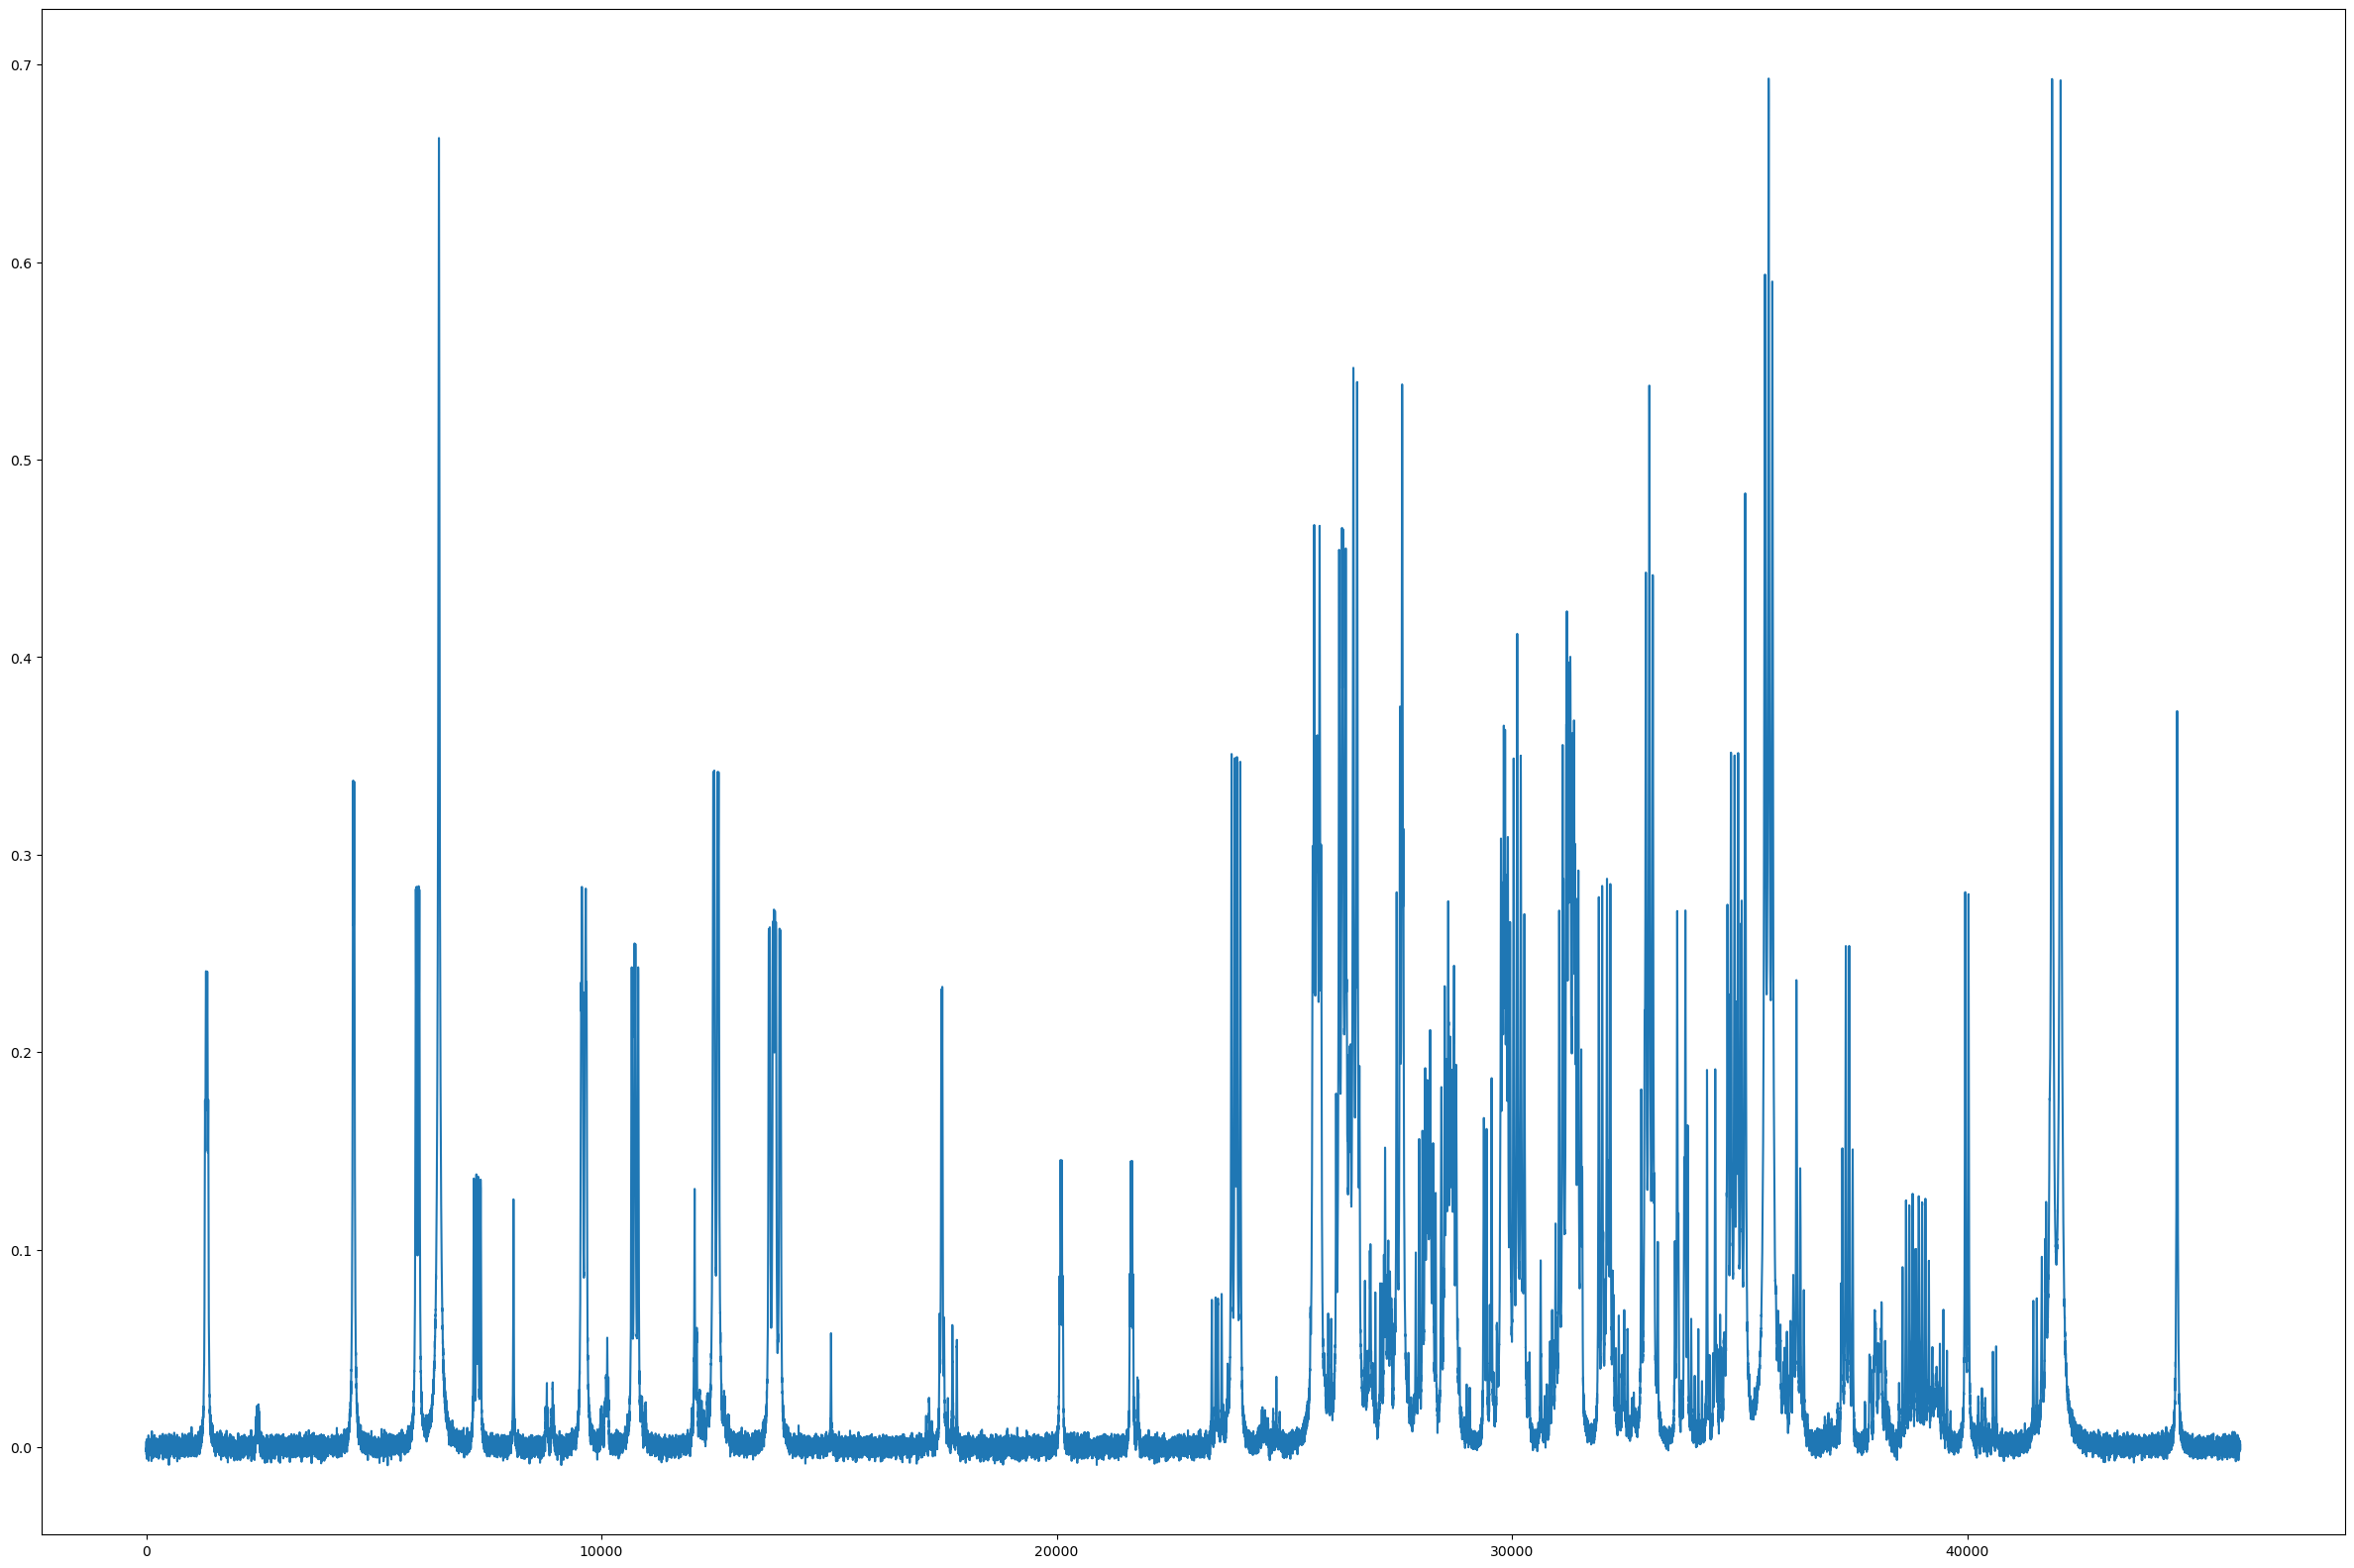

In [19]:
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.show()


In [20]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra (high relative glucose concentration)

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeGlucConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeGlucSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeGlucConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeGlucConc[i].mean().item(),1))

Overall MAPE:  18.566227
--------------------
14.9  - Min Value: 0.013  - Mean Value: 0.6
19.5  - Min Value: 0.0115  - Mean Value: 0.4
14.0  - Min Value: 0.0115  - Mean Value: 0.4
19.17  - Min Value: 0.0115  - Mean Value: 0.6
14.13  - Min Value: 0.0115  - Mean Value: 1.0
26.99  - Min Value: 0.0115  - Mean Value: 1.1
28.55  - Min Value: 0.0115  - Mean Value: 0.8
12.84  - Min Value: 0.0115  - Mean Value: 0.5
11.77  - Min Value: 0.0115  - Mean Value: 0.5
23.83  - Min Value: 0.0115  - Mean Value: 1.1


In [21]:
## Compute absolute percent error statistics on a further high dynamic range dataset

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = HighDynamicRange2Conc[i]
    model_aq.eval()
    Prediction = model_aq(HighDynamicRange2Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "HighDynamicRange2Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "HighDynamicRange2Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(HighDynamicRange2Conc[i].min().item(),4), " - Mean Value:", np.round(HighDynamicRange2Conc[i].mean().item(),1))

Overall MAPE:  108.232216
--------------------
55.2  - Min Value: 0.0062  - Mean Value: 2.1
116.9  - Min Value: 0.006  - Mean Value: 3.7
96.28  - Min Value: 0.0066  - Mean Value: 4.3
81.9  - Min Value: 0.0094  - Mean Value: 4.3
67.84  - Min Value: 0.0068  - Mean Value: 4.9
136.86  - Min Value: 0.005  - Mean Value: 3.8
125.14  - Min Value: 0.0101  - Mean Value: 3.2
83.18  - Min Value: 0.0062  - Mean Value: 3.2
171.34  - Min Value: 0.0053  - Mean Value: 5.3
147.68  - Min Value: 0.0054  - Mean Value: 2.5


In [22]:
ConcConc[5]

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
       device='cuda:0')

In [23]:
model_aq(ConcSpec[5])

tensor([[0.4755, 0.4917, 0.5037, 0.5053, 0.5007, 0.4914, 0.4981, 0.5024, 0.5121,
         0.4967, 0.5173, 0.5177, 0.5066, 0.4839, 0.4956, 0.4995, 0.5072, 0.5003,
         0.4693, 0.5089, 0.5057, 0.5103, 0.5029, 0.4969, 0.5098, 0.4973, 0.4948,
         0.4972, 0.5128, 0.5085, 0.4935, 0.5009, 0.4960, 0.5025, 0.4894, 0.4905,
         0.4874, 0.5190, 0.4946, 0.4887, 0.5087, 0.5105, 0.4901, 0.5098]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [24]:
model_aq(SNR_Spec[1])

tensor([[0.4040, 0.4282, 0.4281, 0.4358, 0.4242, 0.4209, 0.4300, 0.4292, 0.4398,
         0.4261, 0.4433, 0.4376, 0.4376, 0.4120, 0.4291, 0.4330, 0.4368, 0.4245,
         0.4039, 0.4393, 0.4427, 0.4409, 0.4311, 0.4305, 0.4408, 0.4299, 0.4241,
         0.4336, 0.4430, 0.4388, 0.4233, 0.4286, 0.4256, 0.4333, 0.4191, 0.4152,
         0.4201, 0.4527, 0.4227, 0.4214, 0.4408, 0.4379, 0.4201, 0.4371]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [25]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(SNR_Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SNR_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SNR_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  2.2032015375304677
--------------------
1.96
1.88
2.1
2.19
1.86
2.11
2.21
2.88
2.67
2.17


In [26]:
## Compute absolute percent error statistics on a dataset with singlets added at random

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(Singlet_Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SingletExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SingletExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  9.707842181903365
--------------------
2.01
1.93
1.89
2.27
10.6
10.8
11.02
14.48
19.3
22.79


In [27]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(QrefSensSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "QrefSensitivity_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "QrefSensitivity_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  101.1744031541829
--------------------
9.64
34.61
56.5
78.57
98.6
116.68
131.9
147.01
162.3
175.95


In [28]:
Pred = model_aq(OtherValSpectra[0])
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 1")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[1])
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 2")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[2])
Pred[0][Pred[0] < 0] = 0
print("HD-Range 1 - 0.01s and 20s")
print(Pred[0])

Pred = model_aq(OtherValSpectra[3])
Pred[0][Pred[0] < 0] = 0
print("HD-Range 2 - 0s and 20s")
print(Pred[0])

Sinusoidal Baseline 1
tensor([0.5271, 0.4763, 0.3356, 0.5673, 0.4763, 0.5113, 0.4551, 0.5536, 0.5303,
        0.3758, 0.4147, 0.5549, 0.4130, 0.6060, 0.4634, 0.5366, 0.4971, 0.4352,
        0.4618, 0.3911, 0.5374, 0.6590, 0.3374, 0.4677, 0.4971, 0.4277, 0.5045,
        0.5923, 0.5033, 0.4531, 0.4279, 0.6208, 0.4852, 0.4074, 0.4434, 0.4598,
        0.4005, 0.3784, 0.5293, 0.3630, 0.4116, 0.4183, 0.4465, 0.4139],
       device='cuda:0', grad_fn=<SelectBackward0>)
___________
___________
Sinusoidal Baseline 2
tensor([0.2706, 0.6439, 0.2005, 0.5519, 0.3535, 0.4489, 0.4125, 0.3494, 0.5527,
        0.5055, 0.4566, 0.5154, 0.8021, 0.3257, 0.6423, 0.2673, 0.7711, 0.4946,
        0.4173, 0.4589, 0.3888, 0.3783, 0.6780, 0.4181, 0.4387, 0.4014, 0.3130,
        0.1600, 0.5314, 0.4302, 0.4278, 0.3494, 0.3352, 0.5468, 0.4852, 0.4981,
        0.5431, 0.5857, 0.5357, 0.4779, 0.4556, 0.7699, 0.3517, 0.2746],
       device='cuda:0', grad_fn=<SelectBackward0>)
___________
___________
HD-Range 1 - 0.01s a